---
# **Dependencies**
---

In [ ]:
#한글 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# h2o 설치
! apt-get install default-jre
!java -version
! pip install h2o

#런타임 다시 시작
import os
os.kill(os.getpid(), 9)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (39.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

---
# **Import Packages**
---

In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')
mount_dir = '/content/drive/MyDrive/weather_con'

sns.set_style("white")
sns.set_context("talk")
plt.rc('font', family='NanumBarunGothic')

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

import plotly.io as pio
import plotly.express as px
pio.templates.default = "plotly_white"

Mounted at /content/drive


In [3]:
import h2o
h2o.init()
from h2o.estimators import H2OTargetEncoderEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid import H2OGridSearch

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0h9jhg12
  JVM stdout: /tmp/tmp0h9jhg12/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0h9jhg12/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.4
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_rlwkd1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.365 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


---
# **Import Data**
---

In [4]:
train_dt = pd.read_csv(mount_dir+'/train_data.csv', encoding='cp949', index_col=0)
train_dt['yyyymmdd'] = pd.to_datetime(train_dt['yyyymmdd'], format = '%Y-%m-%d')

test_dt = pd.read_csv(mount_dir+'/test_data.csv', encoding='cp949', index_col=0)
test_dt['yyyymmdd'] = pd.to_datetime(test_dt['yyyymmdd'], format = '%Y-%m-%d')
test_dt.drop(columns='frequency', inplace=True)

print(train_dt.shape, test_dt.shape)

(49674, 68) (12444, 64)


In [5]:
train = train_dt[train_dt['yyyymmdd'] < datetime(2015,7,1)]
valid = train_dt[train_dt['yyyymmdd'] >= datetime(2015,7,1)]

hf_train = h2o.H2OFrame(train)
hf_valid = h2o.H2OFrame(valid)
hf_test = h2o.H2OFrame(test_dt)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
# 분석 변수 분류
main_col2 = ['area', 'sex', 'weekday', 'is_firstday', 'is_holiday']
fore_col2 = ['예보최대기온', '예보최소기온', '예보평균기온', '최소예보습도', '평균예보습도', '예보풍속']
lag_col2 = ['1일 전 평균기온', '1일 전 최저기온', '1일 전 최고기온', '1일 전 평균풍속', '1일 전 평균이슬점온도', '1일 전 최소상대습도', '1일 전 평균상대습도', '1일 전 최고해면기압',
       '1일 전 최저해면기압', '1일 전 합계일조시간', '1일 전 일교차', '1일 전 기압차', '1일 전 SO2',  '1일 전 CO', '1일 전 O3', '1일 전 NO2', '1일 전 PM10']
acc_col2 = ['acc_causalty_1000pop']
pop_col2 = [ 'pop', 'old']
health_col2 = ['hpts_rate', 'dbts_rate', 'old_rate' ]
hospital_col2 = ['n_doctor_per1000pop', 'n_bed_per1000pop']

predictors = main_col2 + fore_col2 + lag_col2 + acc_col2 + pop_col2 + hospital_col2 + health_col2 + ['log_sum_rn']
response_col = 'frequency'
print(len(predictors))

37


In [7]:
cc = pd.Series(train_dt.columns)
pp = pd.Series(predictors)
cc[~cc.isin(predictors)]

0                yyyymmdd
3               frequency
4                    year
5                   month
7                  yyyymm
8                  season
9             kor_weekday
10                 sum_rn
11                    SO2
12                     CO
13                     O3
14                    NO2
15                   PM10
16            strong_wind
17             heavy_rain
18                typhoon
19             heavy_snow
21                  smock
22                   hpts
23                   dbts
25             n_check_up
26               n_doctor
27                  n_bed
28             smock_rate
34    n_doctor_per1000old
35       n_bed_per1000old
36          acc_occurence
37              acc_death
38            acc_injured
40           acc_causalty
44             yyyymmdd.1
dtype: object

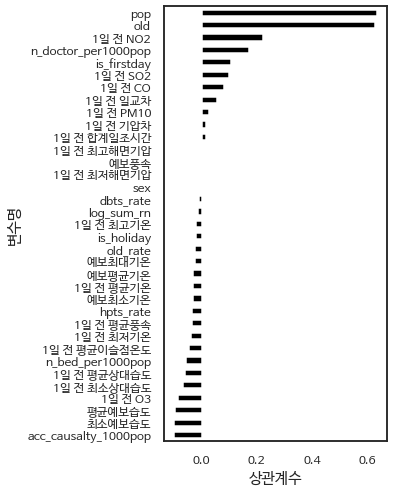

In [8]:
fig, ax = plt.subplots(figsize=(4, 8))
_ = pd.DataFrame(train_dt[predictors + [response_col]].corr()[response_col]).iloc[:-1].sort_values(by='frequency').plot(kind='barh', ax=ax, colormap='gnuplot')
_.set_xlabel("상관계수", fontsize=15)
_.set_ylabel("변수명", fontsize=15)
_.tick_params(labelsize=12)
ax.get_legend().remove()

---
# **GBM Modeling**
---

### 🔵 max_depth grid search

In [25]:
gbm_hp_0 =  {  "max_depth": list(np.arange(1,20,1))  }
gbm_sc_0 = {"strategy": "Cartesian" }
gbm_model_0= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid_0= H2OGridSearch(model=gbm_model_0, hyper_params=gbm_hp_0, search_criteria=gbm_sc_0, grid_id="gbm_grid_00")
%time gbm_grid_0.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 7.52 s, sys: 709 ms, total: 8.23 s
Wall time: 12min 17s
      max_depth             model_ids  residual_deviance
0           4.0   gbm_grid_00_model_4           1.455990
1           3.0   gbm_grid_00_model_3           1.457062
2           5.0   gbm_grid_00_model_5           1.460401
3           6.0   gbm_grid_00_model_6           1.464563
4           2.0   gbm_grid_00_model_2           1.472478
5           7.0   gbm_grid_00_model_7           1.479273
6           8.0   gbm_grid_00_model_8           1.493855
7           9.0   gbm_grid_00_model_9           1.521105
8          10.0  gbm_grid_00_model_10           1.537589
9           1.0   gbm_grid_00_model_1           1.545660
10         11.0  gbm_grid_00_model_11           1.563733
11         12.0  gbm_grid_00_model_12           1.581137
12         13.0  gbm_grid_00_model_13           1.606203
13         14.0  gbm_grid_00_model_

### max_depth 결과

In [26]:
gbm_rmse_0 = gbm_grid_0.sorted_metric_table()
gbm_rmse_0['xval_rmse'] = np.sqrt(gbm_rmse_0['residual_deviance'] )
gbm_rmse_0['valid_rmse'] = pd.Series([gbm_grid_0.models[i].rmse(valid=True) for i in list(np.arange(0,len(gbm_rmse_0),1))])
gbm_rmse_0.sort_values(by='valid_rmse', ascending=True)

,,max_depth,model_ids,residual_deviance,xval_rmse,valid_rmse
0,,4.0,gbm_grid_00_model_4,1.455990,1.206644,1.223090
1,,3.0,gbm_grid_00_model_3,1.457062,1.207088,1.224451
2,,5.0,gbm_grid_00_model_5,1.460401,1.208470,1.224771
3,,6.0,gbm_grid_00_model_6,1.464563,1.210191,1.228139
5,,7.0,gbm_grid_00_model_7,1.479273,1.216254,1.229118
4,,2.0,gbm_grid_00_model_2,1.472478,1.213457,1.229164
6,,8.0,gbm_grid_00_model_8,1.493855,1.222234,1.233741
7,,9.0,gbm_grid_00_model_9,1.521105,1.233331,1.240020
8,,10.0,gbm_grid_00_model_10,1.537589,1.239995,1.244737
10,,11.0,gbm_grid_00_model_11,1.563733,1.250493,1.246934


In [98]:
fig = px.scatter(gbm_rmse_0, x='max_depth', y='valid_rmse',  width=300, height=250, color_discrete_sequence=['#0052cc'])
fig.update_layout(  font=dict(size=15) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

### 🔵learn_rate, ntrees grid search

In [36]:
gbm_sc =  {"strategy": "RandomDiscrete", 
                        "max_runtime_secs":60*60*1,
                        "max_models": 100,
                        "stopping_metric": "RMSE",
                        "stopping_tolerance": 0.00001,
                        "stopping_rounds": 5
                        }
gbm_hp = { 'learn_rate':  list(np.arange(40, 110, 6)/1000),
                         'ntrees': [50], 'learn_rate_annealing' : [0.99],
                        'max_depth' : [4], 'min_rows' : [50],
                        'sample_rate' : [0.7], 'col_sample_rate_per_tree' :  [0.9] }
gbm_model= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid= H2OGridSearch(model=gbm_model, hyper_params=gbm_hp, search_criteria=gbm_sc, grid_id="gbm_grid_001")
%time gbm_grid.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 2.48 s, sys: 234 ms, total: 2.72 s
Wall time: 3min 34s
      col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                          0.9       0.106                  0.99        4.0   
1                          0.9       0.094                  0.99        4.0   
2                          0.9       0.100                  0.99        4.0   
3                          0.9       0.088                  0.99        4.0   
4                          0.9       0.082                  0.99        4.0   
5                          0.9       0.076                  0.99        4.0   
6                          0.9       0.070                  0.99        4.0   
7                          0.9       0.064                  0.99        4.0   
8                          0.9       0.058                  0.99        4.0   
9                          0.9       0.052  

In [37]:
gbm_hp = { 'learn_rate':  list(np.arange(40, 110, 6)/1000),
                         'ntrees': [70], 'learn_rate_annealing' : [0.99],
                        'max_depth' : [4], 'min_rows' : [50],
                        'sample_rate' : [0.7], 'col_sample_rate_per_tree' :  [0.9] }
gbm_model= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid= H2OGridSearch(model=gbm_model, hyper_params=gbm_hp, search_criteria=gbm_sc, grid_id="gbm_grid_001")
%time gbm_grid.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 3.47 s, sys: 333 ms, total: 3.8 s
Wall time: 4min 51s
      col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                          0.9       0.106                  0.99        4.0   
1                          0.9       0.106                  0.99        4.0   
2                          0.9       0.088                  0.99        4.0   
3                          0.9       0.100                  0.99        4.0   
4                          0.9       0.094                  0.99        4.0   
5                          0.9       0.094                  0.99        4.0   
6                          0.9       0.082                  0.99        4.0   
7                          0.9       0.076                  0.99        4.0   
8                          0.9       0.100                  0.99        4.0   
9                          0.9       0.088   

In [38]:
gbm_hp = { 'learn_rate':  list(np.arange(40, 110, 6)/1000),
                         'ntrees': [100], 'learn_rate_annealing' : [0.99],
                        'max_depth' : [4], 'min_rows' : [50],
                        'sample_rate' : [0.7], 'col_sample_rate_per_tree' :  [0.9] }
gbm_model= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid= H2OGridSearch(model=gbm_model, hyper_params=gbm_hp, search_criteria=gbm_sc, grid_id="gbm_grid_001")
%time gbm_grid.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 4.78 s, sys: 481 ms, total: 5.26 s
Wall time: 6min 51s
      col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                          0.9       0.106                  0.99        4.0   
1                          0.9       0.094                  0.99        4.0   
2                          0.9       0.106                  0.99        4.0   
3                          0.9       0.076                  0.99        4.0   
4                          0.9       0.106                  0.99        4.0   
5                          0.9       0.088                  0.99        4.0   
6                          0.9       0.088                  0.99        4.0   
7                          0.9       0.100                  0.99        4.0   
8                          0.9       0.100                  0.99        4.0   
9                          0.9       0.082  

In [39]:
gbm_hp = { 'learn_rate':  list(np.arange(40, 110, 6)/1000),
                         'ntrees': [150], 'learn_rate_annealing' : [0.99],
                        'max_depth' : [4], 'min_rows' : [50],
                        'sample_rate' : [0.7], 'col_sample_rate_per_tree' :  [0.9] }
gbm_model= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid= H2OGridSearch(model=gbm_model, hyper_params=gbm_hp, search_criteria=gbm_sc, grid_id="gbm_grid_001")
%time gbm_grid.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 6.82 s, sys: 680 ms, total: 7.5 s
Wall time: 10min 11s
      col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                          0.9       0.094                  0.99        4.0   
1                          0.9       0.070                  0.99        4.0   
2                          0.9       0.100                  0.99        4.0   
3                          0.9       0.082                  0.99        4.0   
4                          0.9       0.106                  0.99        4.0   
5                          0.9       0.088                  0.99        4.0   
6                          0.9       0.094                  0.99        4.0   
7                          0.9       0.106                  0.99        4.0   
8                          0.9       0.076                  0.99        4.0   
9                          0.9       0.058  

In [40]:
gbm_hp = { 'learn_rate':  list(np.arange(40, 110, 6)/1000),
                         'ntrees': [120], 'learn_rate_annealing' : [0.99],
                        'max_depth' : [4], 'min_rows' : [50],
                        'sample_rate' : [0.7], 'col_sample_rate_per_tree' :  [0.9] }
gbm_model= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid= H2OGridSearch(model=gbm_model, hyper_params=gbm_hp, search_criteria=gbm_sc, grid_id="gbm_grid_001")
%time gbm_grid.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 6.14 s, sys: 588 ms, total: 6.73 s
Wall time: 8min 23s
      col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                          0.9       0.094                  0.99        4.0   
1                          0.9       0.070                  0.99        4.0   
2                          0.9       0.100                  0.99        4.0   
3                          0.9       0.070                  0.99        4.0   
4                          0.9       0.094                  0.99        4.0   
5                          0.9       0.082                  0.99        4.0   
6                          0.9       0.106                  0.99        4.0   
7                          0.9       0.088                  0.99        4.0   
8                          0.9       0.094                  0.99        4.0   
9                          0.9       0.106  

In [41]:
gbm_hp = { 'learn_rate':  list(np.arange(40, 110, 6)/1000),
                         'ntrees': [140], 'learn_rate_annealing' : [0.99],
                        'max_depth' : [4], 'min_rows' : [50],
                        'sample_rate' : [0.7], 'col_sample_rate_per_tree' :  [0.9] }
gbm_model= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid= H2OGridSearch(model=gbm_model, hyper_params=gbm_hp, search_criteria=gbm_sc, grid_id="gbm_grid_001")
%time gbm_grid.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 7.48 s, sys: 678 ms, total: 8.16 s
Wall time: 9min 48s
       col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                           0.9       0.094                  0.99        4.0   
1                           0.9       0.070                  0.99        4.0   
2                           0.9       0.070                  0.99        4.0   
3                           0.9       0.100                  0.99        4.0   
4                           0.9       0.070                  0.99        4.0   
.. ..                       ...         ...                   ...        ...   
67                          0.9       0.058                  0.99        4.0   
68                          0.9       0.052                  0.99        4.0   
69                          0.9       0.040                  0.99        4.0   
70                          0.9   

### learn_rate, ntrees 결과

In [42]:
gbm_rmse = gbm_grid.sorted_metric_table()
gbm_rmse['xval_rmse'] = np.sqrt(gbm_rmse['residual_deviance'] )
gbm_rmse['valid_rmse'] = pd.Series([gbm_grid.models[i].rmse(valid=True) for i in list(np.arange(0,len(gbm_rmse),1))])
gbm_rmse.sort_values(by='valid_rmse', ascending=True)

,,col_sample_rate_per_tree,learn_rate,learn_rate_annealing,max_depth,min_rows,ntrees,sample_rate,model_ids,residual_deviance,xval_rmse,valid_rmse
19,,0.9,0.076,0.99,4.0,50.0,150.0,0.7,gbm_grid_001_model_39,1.456783,1.206972,1.219257
26,,0.9,0.100,0.99,4.0,50.0,70.0,0.7,gbm_grid_001_model_17,1.457372,1.207216,1.219930
23,,0.9,0.100,0.99,4.0,50.0,100.0,0.7,gbm_grid_001_model_35,1.457069,1.207091,1.220278
24,,0.9,0.106,0.99,4.0,50.0,120.0,0.7,gbm_grid_001_model_52,1.457131,1.207117,1.220291
22,,0.9,0.082,0.99,4.0,50.0,140.0,0.7,gbm_grid_001_model_71,1.456878,1.207012,1.220359
...,...,...,...,...,...,...,...,...,...,...,...,...
67,,0.9,0.058,0.99,4.0,50.0,50.0,0.7,gbm_grid_001_model_5,1.482083,1.217408,1.234465
68,,0.9,0.052,0.99,4.0,50.0,50.0,0.7,gbm_grid_001_model_9,1.493112,1.221930,1.238185
69,,0.9,0.040,0.99,4.0,50.0,70.0,0.7,gbm_grid_001_model_19,1.496988,1.223515,1.240475
70,,0.9,0.046,0.99,4.0,50.0,50.0,0.7,gbm_grid_001_model_4,1.510385,1.228977,1.246751


In [43]:
rmse01 = gbm_rmse.sort_values(['valid_rmse'], ascending=True).drop_duplicates(['ntrees'])
rmse01

,,col_sample_rate_per_tree,learn_rate,learn_rate_annealing,max_depth,min_rows,ntrees,sample_rate,model_ids,residual_deviance,xval_rmse,valid_rmse
19,,0.9,0.076,0.99,4.0,50.0,150.0,0.7,gbm_grid_001_model_39,1.456783,1.206972,1.219257
26,,0.9,0.100,0.99,4.0,50.0,70.0,0.7,gbm_grid_001_model_17,1.457372,1.207216,1.219930
23,,0.9,0.100,0.99,4.0,50.0,100.0,0.7,gbm_grid_001_model_35,1.457069,1.207091,1.220278
24,,0.9,0.106,0.99,4.0,50.0,120.0,0.7,gbm_grid_001_model_52,1.457131,1.207117,1.220291
22,,0.9,0.082,0.99,4.0,50.0,140.0,0.7,gbm_grid_001_model_71,1.456878,1.207012,1.220359
48,,0.9,0.100,0.99,4.0,50.0,50.0,0.7,gbm_grid_001_model_3,1.461681,1.209000,1.220752


In [52]:
fig = px.line(gbm_rmse.sort_values(by=['ntrees' , 'learn_rate'], ascending=True).reset_index(drop=True), x='learn_rate', y='valid_rmse', 
                 width=500, height=250, color='ntrees')
fig.update_layout(  font=dict(size=18), legend=dict( orientation="h", yanchor="top", y=1.5, xanchor="center", x=0.4, font=dict(size=15)) )
fig.update_xaxes( title_font = {"size": 23})
fig.update_yaxes( title_font = {"size": 23})
fig.show()

In [53]:
fig = px.line(gbm_rmse.sort_values(by=['ntrees' , 'learn_rate'], ascending=True).reset_index(drop=True), x='learn_rate', y='valid_rmse', 
                 width=300, height=250, color='ntrees')
fig.update_layout(  font=dict(size=15), showlegend=False )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

### 🔵 min_rows gird search

In [ ]:
gbm_sc_02= {"strategy": "RandomDiscrete", 
                        "max_runtime_secs":60*60*4,
                        "max_models": 600,
                        "stopping_metric": "RMSE",
                        "stopping_tolerance": 0.00001,
                        "stopping_rounds": 5
                        }

In [58]:
gbm_hp_02= { 'learn_rate':  [0.087, 0.088, 0.089],
                         'ntrees': [100],
                        'learn_rate_annealing' : [0.99],
                        'max_depth' : [3, 4],
                        'min_rows' : [8, 16, 20, 32, 64, 80, 128],
                        'sample_rate' : [0.7],
                        'col_sample_rate_per_tree' :  [0.9]
                        }

gbm_model_02= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid_02= H2OGridSearch(model=gbm_model_02, hyper_params=gbm_hp_02, search_criteria=gbm_sc_02, grid_id="gbm_grid_0002")
%time gbm_grid_02.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 16 s, sys: 1.45 s, total: 17.5 s
Wall time: 26min 15s
      col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                          0.9       0.089                  0.99        4.0   
1                          0.9       0.087                  0.99        3.0   
2                          0.9       0.088                  0.99        4.0   
3                          0.9       0.087                  0.99        3.0   
4                          0.9       0.087                  0.99        4.0   
5                          0.9       0.088                  0.99        3.0   
6                          0.9       0.088                  0.99        4.0   
7                          0.9       0.088                  0.99        4.0   
8                          0.9       0.087                  0.99        3.0   
9                          0.9       0.089   

In [63]:
gbm_hp_02= { 'learn_rate':  [0.087, 0.088, 0.089],
                         'ntrees': [100],
                        'learn_rate_annealing' : [0.99],
                        'max_depth' : [3, 4],
                        'min_rows' : [35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 67, 70, 73, 76, 79, 82, 85, 88],
                        'sample_rate' : [0.7],
                        'col_sample_rate_per_tree' :  [0.9]
                        }

gbm_model_02= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid_02= H2OGridSearch(model=gbm_model_02, hyper_params=gbm_hp_02, search_criteria=gbm_sc_02, grid_id="gbm_grid_0002")
%time gbm_grid_02.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 45 s, sys: 3.89 s, total: 48.9 s
Wall time: 1h 10min 26s
        col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                            0.9       0.089                  0.99        4.0   
1                            0.9       0.089                  0.99        4.0   
2                            0.9       0.089                  0.99        4.0   
3                            0.9       0.087                  0.99        4.0   
4                            0.9       0.089                  0.99        4.0   
..  ..                       ...         ...                   ...        ...   
145                          0.9       0.087                  0.99        4.0   
146                          0.9       0.087                  0.99        3.0   
147                          0.9       0.087                  0.99        4.0   
148                   

In [82]:
gbm_hp_02= { 'learn_rate':  [0.087, 0.088, 0.089],
                         'ntrees': [100],
                        'learn_rate_annealing' : [0.99],
                        'max_depth' : [3, 4],
                        'min_rows' : [2, 4, 95, 100, 150, 200, 256],
                        'sample_rate' : [0.7],
                        'col_sample_rate_per_tree' :  [0.9]
                        }

gbm_model_02= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid_02= H2OGridSearch(model=gbm_model_02, hyper_params=gbm_hp_02, search_criteria=gbm_sc_02, grid_id="gbm_grid_0002")
%time gbm_grid_02.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 20.2 s, sys: 1.51 s, total: 21.7 s
Wall time: 24min 21s
        col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                            0.9       0.089                  0.99        4.0   
1                            0.9       0.089                  0.99        4.0   
2                            0.9       0.089                  0.99        4.0   
3                            0.9       0.087                  0.99        4.0   
4                            0.9       0.089                  0.99        4.0   
..  ..                       ...         ...                   ...        ...   
187                          0.9       0.087                  0.99        4.0   
188                          0.9       0.089                  0.99        3.0   
189                          0.9       0.088                  0.99        4.0   
190                    

In [85]:
gbm_hp_02= { 'learn_rate':  [0.087, 0.088, 0.089],
                         'ntrees': [100],
                        'learn_rate_annealing' : [0.99],
                        'max_depth' : [3, 4],
                        'min_rows' : [160, 170, 180, 190, 194, 198, 200, 205, 210, 220],
                        'sample_rate' : [0.7],
                        'col_sample_rate_per_tree' :  [0.9]
                        }

gbm_model_02= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid_02= H2OGridSearch(model=gbm_model_02, hyper_params=gbm_hp_02, search_criteria=gbm_sc_02, grid_id="gbm_grid_0002")
%time gbm_grid_02.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 21.6 s, sys: 2.06 s, total: 23.7 s
Wall time: 31min 15s
        col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                            0.9       0.089                  0.99        4.0   
1                            0.9       0.089                  0.99        4.0   
2                            0.9       0.089                  0.99        4.0   
3                            0.9       0.087                  0.99        4.0   
4                            0.9       0.089                  0.99        4.0   
..  ..                       ...         ...                   ...        ...   
241                          0.9       0.087                  0.99        4.0   
242                          0.9       0.087                  0.99        3.0   
243                          0.9       0.088                  0.99        4.0   
244                    

In [88]:
gbm_hp_02= { 'learn_rate':  [0.087, 0.088, 0.089],
                         'ntrees': [100],
                        'learn_rate_annealing' : [0.99],
                        'max_depth' : [3, 4],
                        'min_rows' : [110, 120, 130, 140],
                        'sample_rate' : [0.7],
                        'col_sample_rate_per_tree' :  [0.9]
                        }

gbm_model_02= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid_02= H2OGridSearch(model=gbm_model_02, hyper_params=gbm_hp_02, search_criteria=gbm_sc_02, grid_id="gbm_grid_0002")
%time gbm_grid_02.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 13.8 s, sys: 1.25 s, total: 15.1 s
Wall time: 13min 54s
        col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                            0.9       0.089                  0.99        4.0   
1                            0.9       0.089                  0.99        4.0   
2                            0.9       0.089                  0.99        4.0   
3                            0.9       0.087                  0.99        4.0   
4                            0.9       0.089                  0.99        4.0   
..  ..                       ...         ...                   ...        ...   
265                          0.9       0.088                  0.99        4.0   
266                          0.9       0.087                  0.99        3.0   
267                          0.9       0.088                  0.99        4.0   
268                    

In [93]:
gbm_hp_02= { 'learn_rate':  [0.087, 0.088, 0.089],
                         'ntrees': [100],
                        'learn_rate_annealing' : [0.99],
                        'max_depth' : [3, 4],
                        'min_rows' : [230, 240, 265, 270, 300, 330, 350, 380],
                        'sample_rate' : [0.7],
                        'col_sample_rate_per_tree' :  [0.9]
                        }

gbm_model_02= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid_02= H2OGridSearch(model=gbm_model_02, hyper_params=gbm_hp_02, search_criteria=gbm_sc_02, grid_id="gbm_grid_0002")
%time gbm_grid_02.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 21.6 s, sys: 1.88 s, total: 23.4 s
Wall time: 29min 5s
        col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                            0.9       0.089                  0.99        4.0   
1                            0.9       0.089                  0.99        4.0   
2                            0.9       0.089                  0.99        4.0   
3                            0.9       0.087                  0.99        4.0   
4                            0.9       0.089                  0.99        4.0   
..  ..                       ...         ...                   ...        ...   
313                          0.9       0.089                  0.99        4.0   
314                          0.9       0.089                  0.99        4.0   
315                          0.9       0.088                  0.99        3.0   
316                     

### min_rows 결과

In [95]:
##
gbm_rmse_02 = gbm_grid_02.sorted_metric_table()
gbm_rmse_02['xval_rmse'] = np.sqrt(gbm_rmse_02['residual_deviance'] )
gbm_rmse_02['valid_rmse'] = pd.Series([gbm_grid_02.models[i].rmse(valid=True) for i in list(np.arange(0,len(gbm_rmse_02),1))])
gbm_rmse_02.sort_values(by='valid_rmse', ascending=True)

,,col_sample_rate_per_tree,learn_rate,learn_rate_annealing,max_depth,min_rows,ntrees,sample_rate,model_ids,residual_deviance,xval_rmse,valid_rmse
248,,0.9,0.089,0.99,4.0,200.0,100.0,0.7,gbm_grid_0002_model_154,1.459065,1.207917,1.219374
237,,0.9,0.089,0.99,4.0,130.0,100.0,0.7,gbm_grid_0002_model_255,1.458830,1.207820,1.219449
200,,0.9,0.088,0.99,4.0,130.0,100.0,0.7,gbm_grid_0002_model_262,1.458390,1.207638,1.219611
64,,0.9,0.089,0.99,4.0,70.0,100.0,0.7,gbm_grid_0002_model_68,1.456832,1.206993,1.219689
30,,0.9,0.088,0.99,4.0,80.0,100.0,0.7,gbm_grid_0002_model_19,1.455961,1.206632,1.219776
...,...,...,...,...,...,...,...,...,...,...,...,...
178,,0.9,0.088,0.99,3.0,8.0,100.0,0.7,gbm_grid_0002_model_15,1.458109,1.207522,1.223790
57,,0.9,0.088,0.99,4.0,4.0,100.0,0.7,gbm_grid_0002_model_182,1.456694,1.206936,1.224047
100,,0.9,0.087,0.99,4.0,20.0,100.0,0.7,gbm_grid_0002_model_27,1.457310,1.207191,1.224082
146,,0.9,0.089,0.99,4.0,8.0,100.0,0.7,gbm_grid_0002_model_17,1.457844,1.207412,1.224205


In [66]:
##
fig = px.scatter(gbm_rmse_02, x='learn_rate', y='valid_rmse', width=400, height=300)
fig.show()

In [96]:
fig = px.scatter(gbm_rmse_02, x='min_rows', y='valid_rmse', width=500, height=400, color_discrete_sequence=['#0052cc'])
fig.update_layout(  font=dict(size=15) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

In [97]:
fig = px.scatter(gbm_rmse_02, x='min_rows', y='valid_rmse', width=300, height=250, color_discrete_sequence=['#0052cc'])
fig.update_layout(  font=dict(size=15) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

### 🔵 learn_rate, ntrees 재탐색

In [102]:
gbm_sc_016= {"strategy": "RandomDiscrete", "max_runtime_secs":60*60*2,"max_models": 200,"stopping_metric": "RMSE","stopping_tolerance": 0.00001,"stopping_rounds": 5}

In [103]:
gbm_hp_016= { 'learn_rate':  [0.07, 0.073, 0.076, 0.079, 0.085, 0.087, 0.088, 0.089, 0.09, 0.092, 0.094, 0.096, 0.01],
                         'ntrees': [100, 130, 140],
                        'learn_rate_annealing' : [0.99],
                        'max_depth' : [3, 4],
                        'min_rows' : [130, 200],
                        'sample_rate' : [0.7],
                        'col_sample_rate_per_tree' :  [0.9]
                        }

gbm_model_016= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid_016= H2OGridSearch(model=gbm_model_016, hyper_params=gbm_hp_016, search_criteria=gbm_sc_016, grid_id="gbm_grid_0002")
%time gbm_grid_016.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 1min 31s, sys: 7.45 s, total: 1min 38s
Wall time: 1h 59min 9s
        col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                            0.9       0.089                  0.99        4.0   
1                            0.9       0.089                  0.99        4.0   
2                            0.9       0.085                  0.99        4.0   
3                            0.9       0.096                  0.99        3.0   
4                            0.9       0.089                  0.99        4.0   
..  ..                       ...         ...                   ...        ...   
457                          0.9       0.010                  0.99        3.0   
458                          0.9       0.010                  0.99        4.0   
459                          0.9       0.010                  0.99        4.0   
460              

In [114]:
gbm_hp_016= { 'learn_rate':  [0.095, 0.097, 0.098, 0.099, 0.01],
                         'ntrees': [100, 140],
                        'learn_rate_annealing' : [0.99],
                        'max_depth' : [4],
                        'min_rows' : [130, 200],
                        'sample_rate' : [0.7],
                        'col_sample_rate_per_tree' :  [0.9]
                        }

gbm_model_016= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
gbm_grid_016= H2OGridSearch(model=gbm_model_016, hyper_params=gbm_hp_016, search_criteria=gbm_sc_016, grid_id="gbm_grid_0002")
%time gbm_grid_016.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 15 s, sys: 1.19 s, total: 16.2 s
Wall time: 13min 59s
        col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                            0.9       0.089                  0.99        4.0   
1                            0.9       0.089                  0.99        4.0   
2                            0.9       0.085                  0.99        4.0   
3                            0.9       0.096                  0.99        3.0   
4                            0.9       0.089                  0.99        4.0   
..  ..                       ...         ...                   ...        ...   
473                          0.9       0.010                  0.99        3.0   
474                          0.9       0.010                  0.99        4.0   
475                          0.9       0.010                  0.99        4.0   
476                      

### 재탐색 결과

In [118]:
gbm_rmse_016 = gbm_grid_016.sorted_metric_table()
gbm_rmse_016['xval_rmse'] = np.sqrt(gbm_rmse_016['residual_deviance'] )
gbm_rmse_016['ntrees'] = gbm_rmse_016['ntrees'].astype(str)
gbm_rmse_016['valid_rmse'] = pd.Series([gbm_grid_016.models[i].rmse(valid=True) for i in list(np.arange(0,len(gbm_rmse_016),1))])
gbm_rmse_016 = gbm_rmse_016[gbm_rmse_016['learn_rate']>0.06]
gbm_rmse_016.sort_values(by='valid_rmse', ascending=True)

,,col_sample_rate_per_tree,learn_rate,learn_rate_annealing,max_depth,min_rows,ntrees,sample_rate,model_ids,residual_deviance,xval_rmse,valid_rmse
423,,0.9,0.096,0.99,4.0,130.0,140.0,0.7,gbm_grid_0002_model_371,1.459982,1.208297,1.219219
365,,0.9,0.089,0.99,4.0,200.0,100.0,0.7,gbm_grid_0002_model_154,1.459065,1.207917,1.219374
347,,0.9,0.089,0.99,4.0,130.0,100.0,0.7,gbm_grid_0002_model_255,1.458830,1.207820,1.219449
57,,0.9,0.085,0.99,4.0,130.0,130.0,0.7,gbm_grid_0002_model_423,1.456177,1.206721,1.219458
311,,0.9,0.098,0.99,4.0,200.0,100.0,0.7,gbm_grid_0002_model_468,1.458494,1.207681,1.219511
...,...,...,...,...,...,...,...,...,...,...,...,...
262,,0.9,0.088,0.99,3.0,8.0,100.0,0.7,gbm_grid_0002_model_15,1.458109,1.207522,1.223790
90,,0.9,0.088,0.99,4.0,4.0,100.0,0.7,gbm_grid_0002_model_182,1.456694,1.206936,1.224047
154,,0.9,0.087,0.99,4.0,20.0,100.0,0.7,gbm_grid_0002_model_27,1.457310,1.207191,1.224082
217,,0.9,0.089,0.99,4.0,8.0,100.0,0.7,gbm_grid_0002_model_17,1.457844,1.207412,1.224205


In [119]:
fig = px.scatter(gbm_rmse_016.sort_values(by=['ntrees' , 'learn_rate'], ascending=True).reset_index(drop=True), x='learn_rate', y='valid_rmse', color='ntrees', width=400, height=300)
fig.show()

In [113]:
fig = px.scatter(gbm_rmse_016, x='max_depth', y='valid_rmse', width=300, height=250, color_discrete_sequence=['#0052cc'])
fig.update_layout(  font=dict(size=15) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

In [138]:
fig = px.scatter(gbm_rmse_016, x='min_rows', y='valid_rmse', width=500, height=250, color='ntrees', color_discrete_sequence=['#0052cc', '#CC0052', '#00CC7A'])
fig.update_layout(  font=dict(size=18), legend=dict( orientation="h", yanchor="top", y=1.5, xanchor="center", x=0.4, font=dict(size=15)) )
fig.update_xaxes( title_font = {"size": 23})
fig.update_yaxes( title_font = {"size": 23})
fig.show()

In [137]:
fig = px.scatter(gbm_rmse_016, x='min_rows', y='valid_rmse', width=300, height=250, color='ntrees', color_discrete_sequence=['#0052cc', '#CC0052', '#00CC7A'])
fig.update_layout(  font=dict(size=15), showlegend=False)
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

### 최종

In [18]:
gbm_sc_0004 = {"strategy": "Cartesian" }
gbm_hp_0004= { 'learn_rate':  [0.085, 0.089, 0.096, 0.098],
                         'ntrees': [100, 130, 140],
                        'learn_rate_annealing' : [0.99],
                        'max_depth' : [3, 4],
                        'min_rows' : [130, 200],
                        'sample_rate' : [0.7],
                        'col_sample_rate_per_tree' :  [0.9]
                        }

gbm_model_0004= H2OGradientBoostingEstimator(nfolds=5, fold_assignment="Modulo", seed=1234, keep_cross_validation_predictions=True, score_each_iteration = True)
gbm_grid_0004= H2OGridSearch(model=gbm_model_0004, hyper_params=gbm_hp_0004, search_criteria=gbm_sc_0004, grid_id="gbm_grid_0004")
%time gbm_grid_0004.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 18.9 s, sys: 1.91 s, total: 20.8 s
Wall time: 31min 11s
      col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                          0.9       0.098                  0.99        3.0   
1                          0.9       0.098                  0.99        3.0   
2                          0.9       0.096                  0.99        3.0   
3                          0.9       0.096                  0.99        3.0   
4                          0.9       0.089                  0.99        3.0   
5                          0.9       0.089                  0.99        3.0   
6                          0.9       0.098                  0.99        3.0   
7                          0.9       0.096                  0.99        3.0   
8                          0.9       0.085                  0.99        3.0   
9                          0.9       0.096 

In [19]:
gbm_rmse_0004 = gbm_grid_0004.sorted_metric_table()
gbm_rmse_0004['xval_rmse'] = np.sqrt(gbm_rmse_0004['residual_deviance'] )
gbm_rmse_0004['ntrees'] = gbm_rmse_0004['ntrees'].astype(str)
gbm_rmse_0004['valid_rmse'] = pd.Series([gbm_grid_0004.models[i].rmse(valid=True) for i in list(np.arange(0,len(gbm_rmse_0004),1))])
gbm_rmse_0004.sort_values(by='valid_rmse', ascending=True)

,,col_sample_rate_per_tree,learn_rate,learn_rate_annealing,max_depth,min_rows,ntrees,sample_rate,model_ids,residual_deviance,xval_rmse,valid_rmse
1,,0.9,0.098,0.99,3.0,130.0,130.0,0.7,gbm_grid_0004_model_20,1.454530,1.206039,1.219145
8,,0.9,0.085,0.99,3.0,130.0,140.0,0.7,gbm_grid_0004_model_33,1.455730,1.206537,1.219180
0,,0.9,0.098,0.99,3.0,130.0,140.0,0.7,gbm_grid_0004_model_36,1.454526,1.206038,1.219251
6,,0.9,0.098,0.99,3.0,130.0,100.0,0.7,gbm_grid_0004_model_4,1.455423,1.206409,1.219390
11,,0.9,0.085,0.99,3.0,130.0,130.0,0.7,gbm_grid_0004_model_17,1.455982,1.206641,1.219392
43,,0.9,0.098,0.99,4.0,200.0,130.0,0.7,gbm_grid_0004_model_32,1.458142,1.207535,1.219644
44,,0.9,0.098,0.99,4.0,200.0,140.0,0.7,gbm_grid_0004_model_48,1.458227,1.207571,1.219669
3,,0.9,0.096,0.99,3.0,130.0,130.0,0.7,gbm_grid_0004_model_19,1.454952,1.206214,1.219688
2,,0.9,0.096,0.99,3.0,130.0,140.0,0.7,gbm_grid_0004_model_35,1.454900,1.206192,1.219727
4,,0.9,0.089,0.99,3.0,130.0,140.0,0.7,gbm_grid_0004_model_34,1.454993,1.206231,1.219798


### 저장

In [142]:
saved_path = h2o.save_grid('/content/drive/MyDrive/weather_con/grid', gbm_grid_0004.grid_id)
saved_path

'/content/drive/MyDrive/weather_con/grid/gbm_grid_0002'

In [10]:
grid = h2o.load_grid('/content/drive/MyDrive/weather_con/grid/gbm_grid_0004')
grid

        col_sample_rate_per_tree  learn_rate  learn_rate_annealing  max_depth  \
0                            0.9       0.089                  0.99        4.0   
1                            0.9       0.089                  0.99        4.0   
2                            0.9       0.085                  0.99        4.0   
3                            0.9       0.096                  0.99        3.0   
4                            0.9       0.089                  0.99        4.0   
..  ..                       ...         ...                   ...        ...   
473                          0.9       0.010                  0.99        3.0   
474                          0.9       0.010                  0.99        4.0   
475                          0.9       0.010                  0.99        4.0   
476                          0.9       0.010                  0.99        3.0   
477                          0.9       0.010                  0.99        3.0   

     min_rows  ntrees  samp

In [54]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

In [59]:
gbm_rmse_0004

,,col_sample_rate_per_tree,learn_rate,learn_rate_annealing,max_depth,min_rows,ntrees,sample_rate,model_ids,residual_deviance,xval_rmse,valid_rmse
0,,0.9,0.098,0.99,3.0,130.0,140.0,0.7,gbm_grid_0004_model_36,1.454526,1.206038,1.219251
1,,0.9,0.098,0.99,3.0,130.0,130.0,0.7,gbm_grid_0004_model_20,1.454530,1.206039,1.219145
2,,0.9,0.096,0.99,3.0,130.0,140.0,0.7,gbm_grid_0004_model_35,1.454900,1.206192,1.219727
3,,0.9,0.096,0.99,3.0,130.0,130.0,0.7,gbm_grid_0004_model_19,1.454952,1.206214,1.219688
4,,0.9,0.089,0.99,3.0,130.0,140.0,0.7,gbm_grid_0004_model_34,1.454993,1.206231,1.219798
5,,0.9,0.089,0.99,3.0,130.0,130.0,0.7,gbm_grid_0004_model_18,1.455076,1.206265,1.219847
6,,0.9,0.098,0.99,3.0,130.0,100.0,0.7,gbm_grid_0004_model_4,1.455423,1.206409,1.219390
7,,0.9,0.096,0.99,3.0,200.0,140.0,0.7,gbm_grid_0004_model_43,1.455700,1.206524,1.219822
8,,0.9,0.085,0.99,3.0,130.0,140.0,0.7,gbm_grid_0004_model_33,1.455730,1.206537,1.219180
9,,0.9,0.096,0.99,3.0,200.0,130.0,0.7,gbm_grid_0004_model_27,1.455877,1.206597,1.219907


['gbm_grid_0004_model_20',
 'gbm_grid_0004_model_33',
 'gbm_grid_0004_model_36',
 'gbm_grid_0004_model_4',
 'gbm_grid_0004_model_17',
 'gbm_grid_0004_model_32',
 'gbm_grid_0004_model_48',
 'gbm_grid_0004_model_19',
 'gbm_grid_0004_model_35',
 'gbm_grid_0004_model_34']

In [82]:
aa = list(gbm_rmse_0004.sort_values(by='valid_rmse', ascending=True).index[:10])
ensemble_grid1 = H2OStackedEnsembleEstimator(model_id="ensemble_grid1", base_models=[gbm_grid_0004.model_ids[i] for i in aa], metalearner_algorithm="deeplearning")
ensemble_grid1.train(x=predictors, y=response_col,  training_frame=hf_train, validation_frame=hf_valid)

stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  ensemble_grid1

No model summary for this model

ModelMetricsRegression: stackedensemble
** Reported on train data. **

MSE: 1.4532546372739206
RMSE: 1.2055101149612644
MAE: 0.8762806467600771
RMSLE: 0.47276521473848593
Mean Residual Deviance: 1.4532546372739206

ModelMetricsRegression: stackedensemble
** Reported on validation data. **

MSE: 1.4860256054371441
RMSE: 1.2190264990709365
MAE: 0.8950190661938979
RMSLE: 0.47644869026690717
Mean Residual Deviance: 1.4860256054371441


In [83]:
ensemble_grid = H2OStackedEnsembleEstimator(model_id="ensemble_grid", base_models=gbm_grid_0004.model_ids[:10], metalearner_algorithm="deeplearning")
ensemble_grid.train(x=predictors, y=response_col,  training_frame=hf_train, validation_frame=hf_valid)

stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  ensemble_grid

No model summary for this model

ModelMetricsRegression: stackedensemble
** Reported on train data. **

MSE: 1.4431911896472058
RMSE: 1.2013289265006508
MAE: 0.8777720230340399
RMSLE: 0.47267586863507194
Mean Residual Deviance: 1.4431911896472058

ModelMetricsRegression: stackedensemble
** Reported on validation data. **

MSE: 1.484522784810221
RMSE: 1.218409941198044
MAE: 0.9050669382852377
RMSLE: 0.48037678428310215
Mean Residual Deviance: 1.484522784810221


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

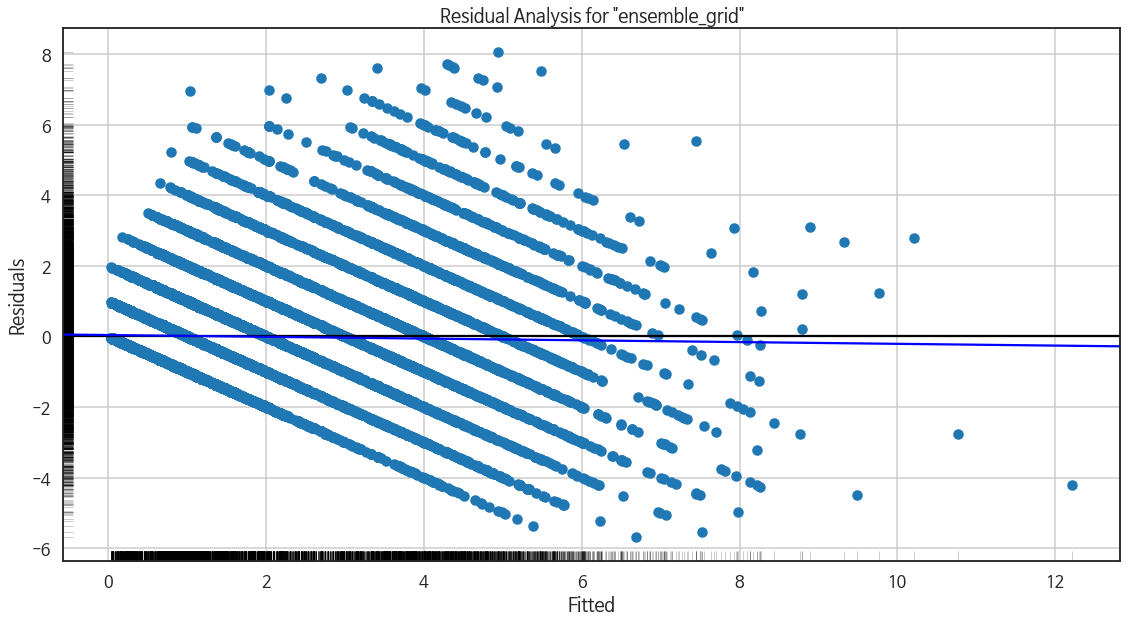

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

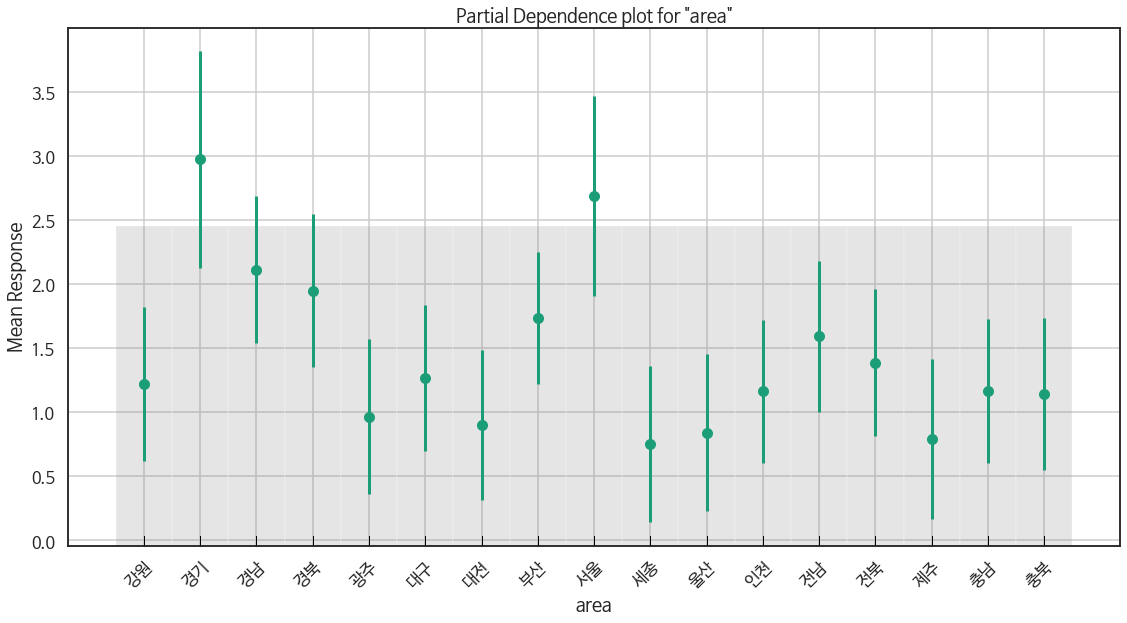

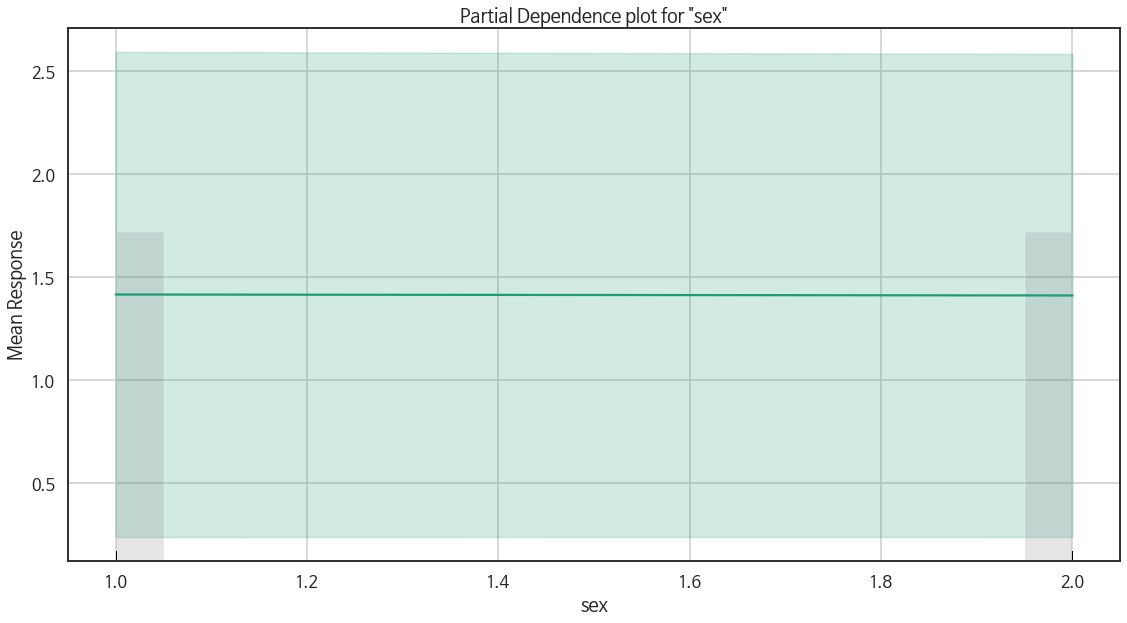

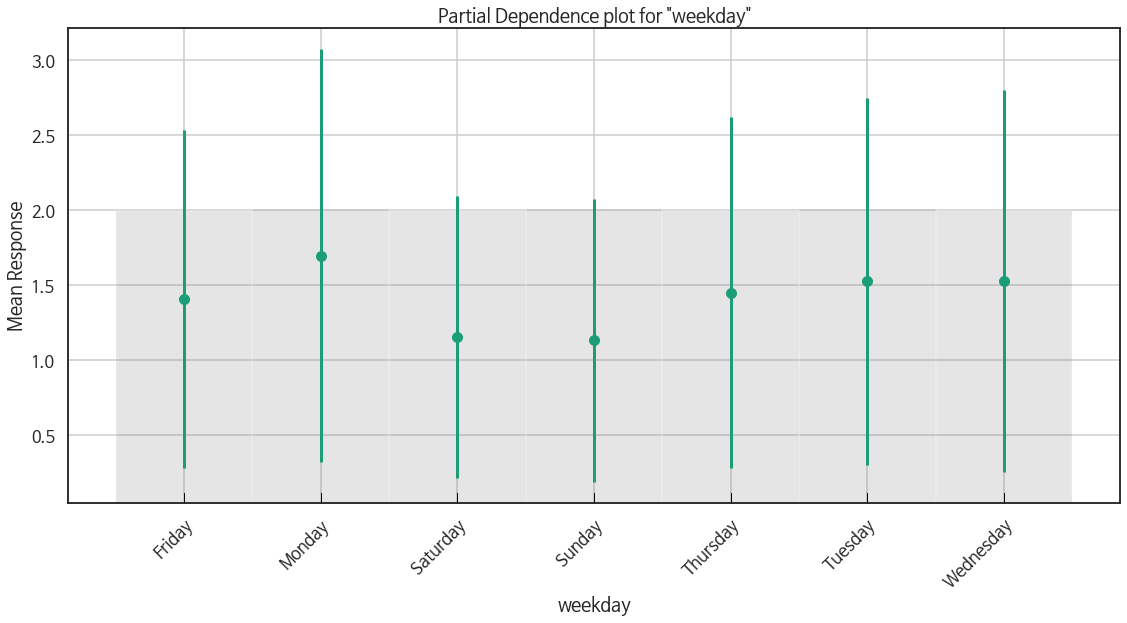

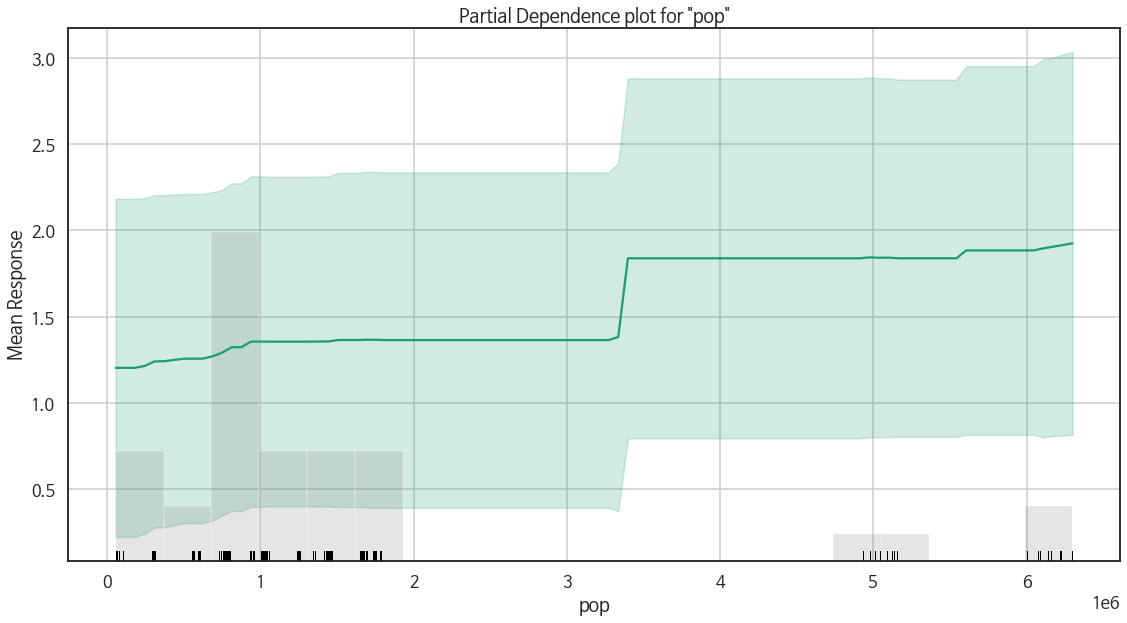

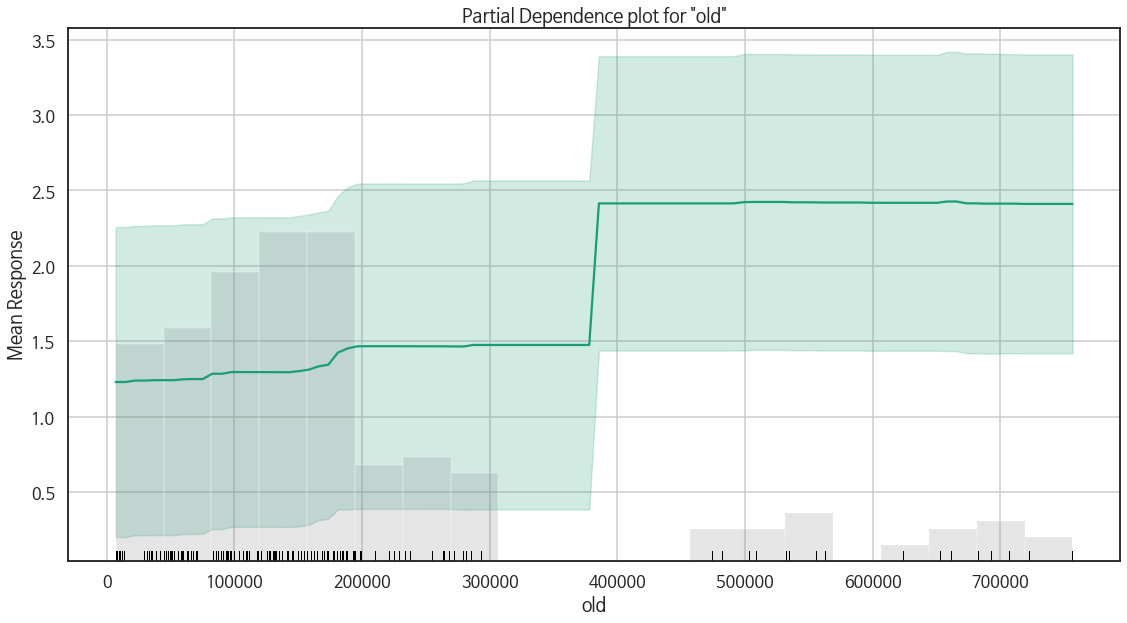

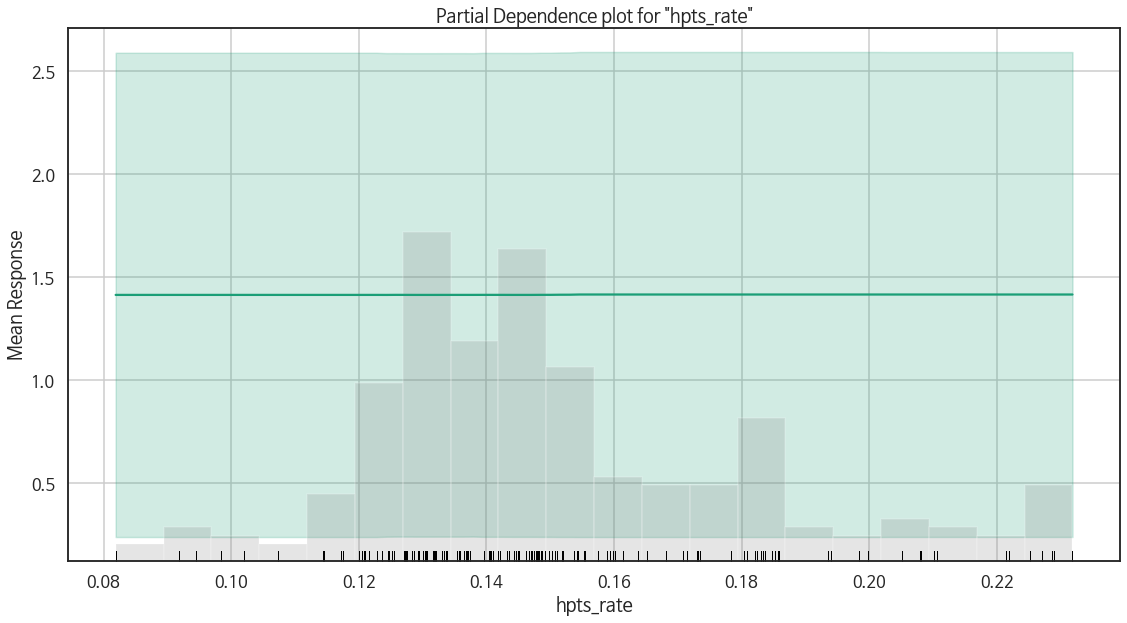

H2OJobCancelled: ignored

<Figure size 1152x648 with 0 Axes>

In [33]:
ensemble_grid.explain(frame=hf_train)

Text(0.5, 1.0, 'Variable Importance')

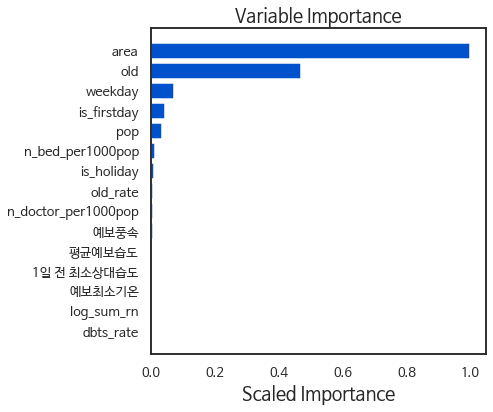

In [72]:
fig, ax = plt.subplots(figsize=(6,6))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")

variables = gbm_grid_0004.models[0]._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = gbm_grid_0004.models[0]._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos[:15], scaled_importance[:15], align='center', color='#0052cc', ecolor='#8e8e8e')
ax.set_yticks(y_pos[:15])
ax.set_yticklabels(variables[:15])
ax.tick_params(labelsize=13)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')

In [88]:
varim = gbm_grid_0004.models[0]._model_json['output']['variable_importances'].as_data_frame()
varim

,variable,relative_importance,scaled_importance,percentage
0,area,183731.234375,1.000000,0.598609
1,old,86038.804688,0.468286,0.280321
2,weekday,12804.116211,0.069689,0.041717
3,is_firstday,7730.223633,0.042074,0.025186
4,pop,6057.904297,0.032972,0.019737
5,n_bed_per1000pop,2129.523682,0.011590,0.006938
6,is_holiday,1432.667725,0.007798,0.004668
7,old_rate,978.435852,0.005325,0.003188
8,n_doctor_per1000pop,829.968628,0.004517,0.002704
9,예보풍속,790.316040,0.004301,0.002575


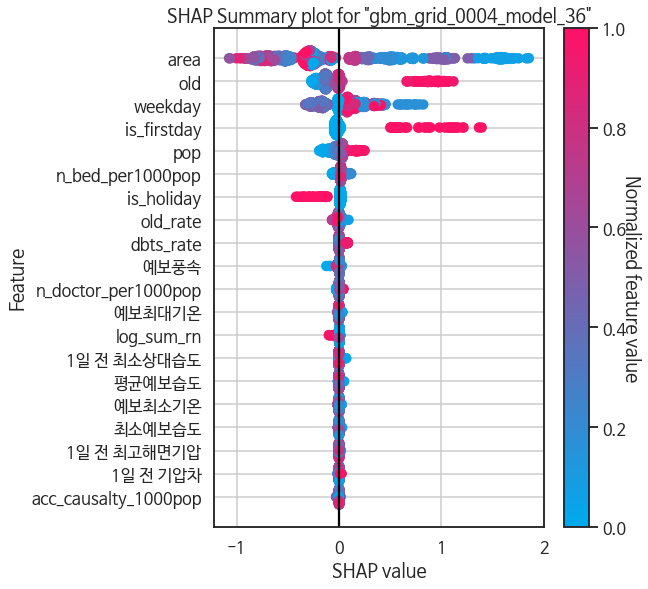

In [86]:
ssp = gbm_grid_0004.models[0].shap_summary_plot(hf_valid)
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(8, 8)

In [58]:
yhat2 = ensemble_grid.predict(hf_test)
output = test_dt[['yyyymmdd', 'area', 'sex']].copy()
output['frequency'] = yhat2.as_data_frame()['predict']
output = output.sort_values(by=['yyyymmdd', 'sex', 'area'], ascending=True)
output.to_csv('/content/drive/MyDrive/weather_con/output/' + '/output'+ '22080801' +'.csv', encoding='CP949',  index = False)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [70]:
yhat2 = gbm_grid_0004.models[0].predict(hf_test)
output = test_dt[['yyyymmdd', 'area', 'sex']].copy()
output['frequency'] = yhat2.as_data_frame()['predict']
output = output.sort_values(by=['yyyymmdd', 'sex', 'area'], ascending=True)
output.to_csv('/content/drive/MyDrive/weather_con/output/' + '/output'+ '22080802' +'.csv', encoding='CP949',  index = False)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [55]:
gbmbest = pathensem = h2o.save_model(model=gbm_grid_0004.models[0], path='/content/drive/MyDrive/weather_con/models/best_model', force=True)
pathensem = h2o.save_model(model=ensemble_grid, path='/content/drive/MyDrive/weather_con/models/best_model', force=True)
pathensem1 =  h2o.save_model(model=ensemble_grid1, path='/content/drive/MyDrive/weather_con/models/best_model', force=True)

In [57]:
gbmbest

'/content/drive/MyDrive/weather_con/models/best_model/gbm_grid_0004_model_36'

In [56]:
pathensem

'/content/drive/MyDrive/weather_con/models/best_model/ensemble_grid'

In [ ]:
pathensem1

In [ ]:
model = h2o.load_model(pathensem)